スパースモデリング第14章　画像のノイズ除去
==
冗長DCT辞書+OMPノイズ除去

In [1]:
from matplotlib.font_manager import FontProperties
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from skimage.io import imread

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

def get_psnr(im, recon):
    """ PSNRを得る """ 
    return 10. * np.log(im.max() / np.sqrt(np.mean((im - recon) ** 2)))

def show_dictionary(A, name=None):
    """ 辞書を表示 """
    n = int(np.sqrt(A.shape[0]))
    m = int(np.sqrt(A.shape[1]))
    A_show = A.reshape((n, n, m, m))
    fig, ax = plt.subplots(m, m, figsize=(4, 4))
    for row in range(m):
        for col in range(m):
            ax[row, col].imshow(A_show[:, :, col, row], cmap='gray', interpolation='Nearest')
            ax[row, col].axis('off')
    if name is not None:
        plt.savefig(name, dpi=220)
        
def OMP(A, b, k0, eps):
    """ 
    直交マッチング追跡(orthogonal matching pursuit; OMP) 
    
    A nxm行列
    b n要素の観測
    k0 xの非ゼロの要素数
    eps 誤差の閾値
    
    戻り値
    x m要素のスパース表現
    S m要素のサポートベクトル
    """
    # 初期化
    x = np.zeros(A.shape[1])
    S = np.zeros(A.shape[1], dtype=np.uint8)
    r = b.copy()
    rr = np.dot(r, r)
    for _ in range(k0):
        # 誤差計算
        err = rr - np.dot(A[:, S == 0].T, r) ** 2
            
        # サポート更新
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
    
        # 解更新
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, b))
        
        # 残差更新
        r = b - np.dot(A, x)
        rr = np.dot(r, r)
        if rr < eps:
            break
            
    return x, S

Barbara
--

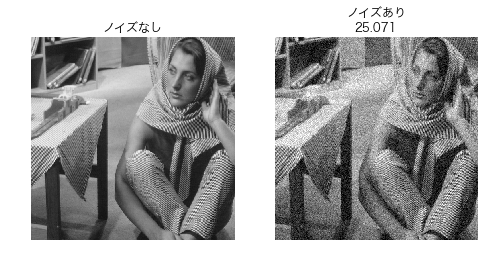

In [2]:
im = imread('barbara.png').astype(np.float)
# Y = im + np.random.randn(im.shape[0], im.shape[1]) * 20.
# Y.tofile('barbara_sig20')
Y = np.fromfile('barbara_sig20').reshape(im.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(im, cmap='gray', interpolation='Nearest', vmin=0, vmax=255)
ax[1].imshow(Y, cmap='gray', interpolation='Nearest', vmin=0, vmax=255)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('ノイズなし')
ax[1].set_title('ノイズあり\n{:.3f}'.format(get_psnr(im, Y)))

冗長DCT辞書
--

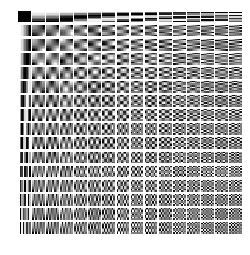

In [5]:
patch_size = 8
dict_size = 16
A_1D = np.zeros((patch_size, dict_size))
for k in np.arange(dict_size):
    for i in np.arange(patch_size):
        A_1D[i, k] = np.cos(i * k * np.pi / float(dict_size))
    if k != 0:
        A_1D[:, k] -= A_1D[:, k].mean()

A_DCT = np.kron(A_1D, A_1D)
show_dictionary(A_DCT)
A_DCT.tofile('A_DCT')

In [6]:
def denoise_with_learned_dictionary(im, A, k0, eps, patch_size=8, lam=0.5, n_iter=1, im0=None):
    """ 学習済み辞書によるノイズ除去 """    
    recon = im.copy()
    for h in range(n_iter):
        patches = extract_patches_2d(recon, (patch_size, patch_size))
        if h == 0:
            q = np.zeros((len(patches), A.shape[1]))
        for i, patch in enumerate(patches):
            if i % 1000 == 0:
                print(i)
            q[i], _ = OMP(A, patch.flatten(), k0, eps=eps)
        recon_patches = (np.dot(A, q.T).T).reshape((-1, patch_size, patch_size))
        recon = reconstruct_from_patches_2d(recon_patches, im.shape)
        recon = (im * lam + recon) / (lam + 1.)
        if im0 is not None:
            print(h, get_psnr(im0, recon))
    return recon

In [7]:
eps = (patch_size ** 2) * (20. ** 2) * 1.15
recon_dct_dictionary = denoise_with_learned_dictionary(Y, A_DCT, 4, eps, im0=im)
recon_dct_dictionary.tofile('recon_dct_dictionary')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


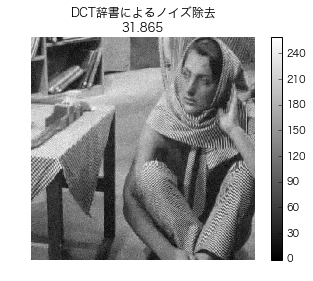

In [8]:
plt.imshow(recon_dct_dictionary, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.title('DCT辞書によるノイズ除去\n{:.3f}'.format(get_psnr(im, recon_dct_dictionary)))
plt.colorbar()